In [1]:
%reload_ext autoreload
%autoreload 2
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import sys

sys.path.insert(0, "../src")

<IPython.core.display.Javascript object>

In [3]:
import gc
import functools
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl

<IPython.core.display.Javascript object>

In [4]:
PATH = Path("../input")

<IPython.core.display.Javascript object>

In [5]:
DAMS = (6071, 6304, 7026, 7629, 7767, 8944, 11107)

<IPython.core.display.Javascript object>

In [6]:
df = pd.read_csv(PATH / "train_folds.csv")

<IPython.core.display.Javascript object>

# 🔥 RainNet ⚡️

## Utils

In [6]:
def visualize(x, y=None, test=False):
    cmap = plt.cm.get_cmap("RdBu")
    cmap = cmap.reversed()
    if test:
        fig, axes = plt.subplots(1, 4, figsize=(10, 10))
        for i, ax in enumerate(axes):
            img = x[:, :, i]
            ax.imshow(img, cmap=cmap)
    else:
        fig, axes = plt.subplots(1, 5, figsize=(10, 10))
        for i, ax in enumerate(axes[:-1]):
            img = x[:, :, i]
            ax.imshow(img, cmap=cmap)
        axes[-1].imshow(y[:, :, 0], cmap=cmap)
    #     plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>

## Resize data

In [7]:
def resize_data(path, folder="train-128"):
    data = np.load(path)
    img1 = data[:, :, :3]
    img2 = data[:, :, 2:]
    img1 = cv2.copyMakeBorder(img1, 4, 4, 4, 4, cv2.BORDER_REFLECT)
    img2 = cv2.copyMakeBorder(img2, 4, 4, 4, 4, cv2.BORDER_REFLECT)
    img2 = img2[:, :, 1:]
    data = np.concatenate([img1, img2], axis=-1)
    np.save(PATH / folder / path.name, data)

<IPython.core.display.Javascript object>

In [5]:
(PATH / "train-128").mkdir(exist_ok=True)

<IPython.core.display.Javascript object>

In [21]:
files = list((PATH / "train").glob("*.npy"))
with ThreadPoolExecutor(8) as e:
    e.map(resize_data, files)

<IPython.core.display.Javascript object>

In [8]:
(PATH / "test-128").mkdir(exist_ok=True)

<IPython.core.display.Javascript object>

In [9]:
test_files = list((PATH / "test").glob("*.npy"))
with ThreadPoolExecutor(8) as e:
    e.map(functools.partial(resize_data, folder="test-128"), test_files)

<IPython.core.display.Javascript object>

## Dataset

In [7]:
class NowcastingDataset(torch.utils.data.Dataset):
    def __init__(self, paths, test=False):
        self.paths = paths
        self.test = test

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        data = np.load(path)
        x = data[:, :, :4]
        x = x / 255.0
        x = x.astype(np.float32)
        x = torch.tensor(x, dtype=torch.float)
        x = x.permute(2, 0, 1)
        if self.test:
            return x
        else:
            y = data[:, :, 4]
            y = y / 255.0
            y = y.astype(np.float32)
            y = torch.tensor(y, dtype=torch.float)
            y = y.unsqueeze(-1)
            y = y.permute(2, 0, 1)

            return x, y

<IPython.core.display.Javascript object>

In [8]:
class NowcastingDataModule(pl.LightningDataModule):
    def __init__(self, df, fold, batch_size, test=False, num_workers=4):
        super().__init__()
        self.df = df
        self.fold = fold
        self.test = test
        self.batch_size = batch_size
        self.num_workers = 4

    def setup(self, stage="train"):
        if stage == "train":
            train_df = self.df[self.df.fold != self.fold]
            val_df = self.df[self.df.fold == self.fold]
            train_paths = [PATH / "train-128" / fn for fn in train_df.filename.values]
            val_paths = [PATH / "train-128" / fn for fn in val_df.filename.values]
            self.train_dataset = NowcastingDataset(train_paths)
            self.val_dataset = NowcastingDataset(val_paths)
        else:
            test_paths = list((PATH / "test-128").glob("*.npy"))
            self.test_dataset = NowcastingDataset(test_paths, test=True)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            pin_memory=True,
            num_workers=self.num_workers,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=2 * self.batch_size,
            pin_memory=True,
            num_workers=self.num_workers,
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_dataset,
            batch_size=2 * self.batch_size,
            pin_memory=True,
            num_workers=self.num_workers,
        )

<IPython.core.display.Javascript object>

In [9]:
# datamodule = NowcastingDataModule(df, fold=0, batch_size=32)
# datamodule.setup()
# for batch in datamodule.train_dataloader():
#     xs, ys = batch
#     x, y = xs[0], ys[0]
#     x = x.permute(1, 2, 0).numpy()
#     y = y.permute(1, 2, 0).numpy()
#     visualize(x, y)
#     break

<IPython.core.display.Javascript object>

## Model

### Loss

In [9]:
class LogCoshLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, inp, targ, epsilon=1e-12):
        error = inp - targ
        return torch.mean(torch.log(torch.cosh(error + epsilon)))

<IPython.core.display.Javascript object>

### Layers

In [10]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, bn=True):
        super().__init__()
        if bn:
            self.net = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
            )
        else:
            self.net = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            )

    def forward(self, x):
        return self.net(x)

<IPython.core.display.Javascript object>

In [11]:
class Encoder(nn.Module):
    def __init__(self, chs=[4, 64, 128, 256, 512, 1024], bn=True):
        super().__init__()
        self.blocks = nn.ModuleList(
            [Block(chs[i], chs[i + 1], bn=bn) for i in range(len(chs) - 1)]
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        ftrs = []
        for block in self.blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs

<IPython.core.display.Javascript object>

In [12]:
class Decoder(nn.Module):
    def __init__(self, chs=[1024, 512, 256, 128, 64], bn=True):
        super().__init__()
        self.chs = chs
        self.tr_convs = nn.ModuleList(
            [
                nn.ConvTranspose2d(chs[i], chs[i], kernel_size=2, stride=2)
                for i in range(len(chs) - 1)
            ]
        )
        self.convs = nn.ModuleList(
            [Block(chs[i] + chs[i + 1], chs[i + 1], bn=bn) for i in range(len(chs) - 1)]
        )

    def forward(self, x, ftrs):
        for i in range(len(self.chs) - 1):
            x = self.tr_convs[i](x)
            ftr = ftrs[i]
            x = torch.cat([ftr, x], dim=1)
            x = self.convs[i](x)
        return x

<IPython.core.display.Javascript object>

### RainNet

In [13]:
class RainNet(pl.LightningModule):
    def __init__(
        self,
        lr=1e-4,
        bn=True,
        enc_chs=[4, 64, 128, 256, 512, 1024],
        dec_chs=[1024, 512, 256, 128, 64],
    ):
        super().__init__()
        self.save_hyperparameters()

        # criterion and metrics
        self.criterion = LogCoshLoss()
        self.train_mae = pl.metrics.MeanAbsoluteError()
        self.val_mae = pl.metrics.MeanAbsoluteError()

        # layers
        self.encoder = Encoder(enc_chs, bn=bn)
        self.decoder = Decoder(dec_chs, bn=bn)
        if bn:
            self.out = nn.Sequential(
                nn.Conv2d(64, 2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(2),
                nn.ReLU(inplace=True),
                nn.Conv2d(2, 1, kernel_size=1, bias=False),
                nn.BatchNorm2d(1),
                nn.ReLU(inplace=True),
            )
        else:
            self.out = nn.Sequential(
                nn.Conv2d(64, 2, kernel_size=3, bias=False, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(2, 1, kernel_size=1, bias=False),
                nn.ReLU(inplace=True),
            )

    def forward(self, x):
        ftrs = self.encoder(x)
        ftrs = list(reversed(ftrs))
        x = self.decoder(ftrs[0], ftrs[1:])
        out = self.out(x)
        return out

    def _shared_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        return loss, y, y_hat

    def training_step(self, batch, batch_idx):
        loss, y, y_hat = self._shared_step(batch, batch_idx)
        self.log("train_loss", loss)
        self.log("train_mae", self.train_mae(y_hat, y))
        return {"loss": loss}

    def training_epoch_end(self, outputs):
        self.log("train_mae", self.train_mae.compute())
        self.train_mae.reset()

    def validation_step(self, batch, batch_idx):
        loss, y, y_hat = self._shared_step(batch, batch_idx)
        self.log("val_loss", loss)
        self.log("val_mae", self.val_mae(y_hat, y))
        return {"loss": loss, "y": y.detach(), "y_hat": y_hat.detach()}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        self.log("loss", avg_loss)
        #         y = torch.cat([x["y"] for x in outputs])
        #         y_hat = torch.cat([x["y_hat"] for x in outputs])
        #         mae = self.mae(y_hat, y)
        self.log("val_mae", self.val_mae.compute())
        print(f"Epoch {self.current_epoch} | MAE: {self.val_mae.compute()}")
        self.val_mae.reset()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        return optimizer

<IPython.core.display.Javascript object>

## Train

In [14]:
model = RainNet()

<IPython.core.display.Javascript object>

In [15]:
datamodule = NowcastingDataModule(df, fold=0, batch_size=64)
datamodule.setup()

<IPython.core.display.Javascript object>

In [16]:
trainer = pl.Trainer(
    gpus=1,
    max_epochs=40,
    precision=16,
    progress_bar_refresh_rate=50,
    #     fast_dev_run=True,
    benchmark=True,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


<IPython.core.display.Javascript object>

### `lr_find`

In [17]:
lr_finder = trainer.tuner.lr_find(model, datamodule)


  | Name      | Type              | Params
------------------------------------------------
0 | criterion | LogCoshLoss       | 0     
1 | train_mae | MeanAbsoluteError | 0     
2 | val_mae   | MeanAbsoluteError | 0     
3 | encoder   | Encoder           | 18 M  
4 | decoder   | Decoder           | 18 M  
5 | out       | Sequential        | 1 K   


Epoch 0 | MAE: 0.05334088206291199


<IPython.core.display.Javascript object>

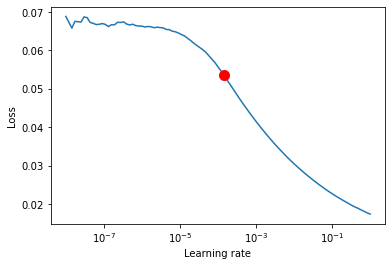

<IPython.core.display.Javascript object>

In [18]:
fig = lr_finder.plot(suggest=True)

In [20]:
model.hparams.lr = lr_finder.suggestion()
model.hparams.lr

0.0001445439770745928

<IPython.core.display.Javascript object>

## `fit`

In [21]:
# model.hparams.lr = 2e-4

<IPython.core.display.Javascript object>

In [22]:
trainer.fit(model, datamodule)


  | Name      | Type              | Params
------------------------------------------------
0 | criterion | LogCoshLoss       | 0     
1 | train_mae | MeanAbsoluteError | 0     
2 | val_mae   | MeanAbsoluteError | 0     
3 | encoder   | Encoder           | 18 M  
4 | decoder   | Decoder           | 18 M  
5 | out       | Sequential        | 1 K   


Epoch 1 | MAE: 0.05334088206291199


Epoch 1 | MAE: 0.014351904392242432


Epoch 2 | MAE: 0.013196761719882488


Epoch 3 | MAE: 0.013001780956983566


Epoch 4 | MAE: 0.012537709437310696


Epoch 5 | MAE: 0.012411631643772125


Epoch 6 | MAE: 0.012339100241661072


Epoch 7 | MAE: 0.01189120952039957


Epoch 8 | MAE: 0.012403431348502636


Epoch 9 | MAE: 0.012217310257256031


Epoch 10 | MAE: 0.012288837693631649


Epoch 11 | MAE: 0.011968758888542652


Epoch 12 | MAE: 0.012066589668393135


Epoch 13 | MAE: 0.011628727428615093


Epoch 14 | MAE: 0.011522951535880566


Epoch 15 | MAE: 0.012007856741547585


Epoch 16 | MAE: 0.011744077317416668


Epoch 17 | MAE: 0.011944593861699104


Epoch 18 | MAE: 0.012012067250907421


Epoch 19 | MAE: 0.011811992153525352


Epoch 20 | MAE: 0.011662784032523632


Epoch 21 | MAE: 0.011700300499796867


Epoch 22 | MAE: 0.011596720665693283


Epoch 23 | MAE: 0.01195605006068945


Epoch 24 | MAE: 0.011828754097223282


Epoch 25 | MAE: 0.011397678405046463


Epoch 26 | MAE: 0.011438102461397648


Epoch 27 | MAE: 0.011640344746410847


Epoch 28 | MAE: 0.011868203990161419


Epoch 29 | MAE: 0.011692555621266365


Epoch 30 | MAE: 0.0124813262373209


Epoch 31 | MAE: 0.011777856387197971


Epoch 32 | MAE: 0.011196047067642212


Epoch 33 | MAE: 0.011469211429357529


Epoch 34 | MAE: 0.011484542861580849


Epoch 35 | MAE: 0.011434459127485752


Epoch 36 | MAE: 0.01203860528767109


Epoch 37 | MAE: 0.011480816639959812


Epoch 38 | MAE: 0.011445727199316025


Epoch 39 | MAE: 0.011705679818987846


1

<IPython.core.display.Javascript object>

In [24]:
trainer.save_checkpoint("rainnet_fold0_bs64_epoch40.ckpt")

<IPython.core.display.Javascript object>

## Inference

In [14]:
model = RainNet.load_from_checkpoint("rainnet_fold0_bs64_epoch40.ckpt")

<IPython.core.display.Javascript object>

In [15]:
datamodule = NowcastingDataModule(df, fold=0, batch_size=128)
datamodule.setup("test")

<IPython.core.display.Javascript object>

In [16]:
preds = []
model.to("cuda")
model.eval()
with torch.no_grad():
    for batch in datamodule.test_dataloader():
        batch = batch.to("cuda")
        imgs = model(batch)
        imgs = imgs.detach().cpu().numpy()
        imgs = imgs[:, 0, 4:124, 4:124]
        imgs = 255.0 * imgs
        imgs = np.round(imgs)
        imgs = np.clip(imgs, 0, 255)
        preds.append(imgs)

preds = np.concatenate(preds)
preds = preds.astype(np.uint8)
preds = preds.reshape(len(preds), -1)

<IPython.core.display.Javascript object>

In [17]:
test_paths = datamodule.test_dataset.paths
test_filenames = [path.name for path in test_paths]

<IPython.core.display.Javascript object>

In [18]:
subm = pd.DataFrame()
subm["file_name"] = test_filenames
for i in tqdm(range(14400)):
    subm[str(i)] = preds[:, i]

<IPython.core.display.Javascript object>

In [19]:
subm.to_csv("rainnet_fold0_epoch40.csv", index=False)
subm.head()

,file_name,0,1,2,3,4,5,6,7,8,...,14390,14391,14392,14393,14394,14395,14396,14397,14398,14399
0,test_00402.npy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,test_00365.npy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,test_00122.npy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,test_01822.npy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,test_01769.npy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

In [ ]:
# test_paths = list((PATH / "test-128").glob("*.npy"))
# test_dataset = NowcastingDataset(paths, test=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, num_workers=4, pin_memory=True)